In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [3]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=True)

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

In [4]:
%time model.simulate()

CPU times: total: 359 ms
Wall time: 1.23 s


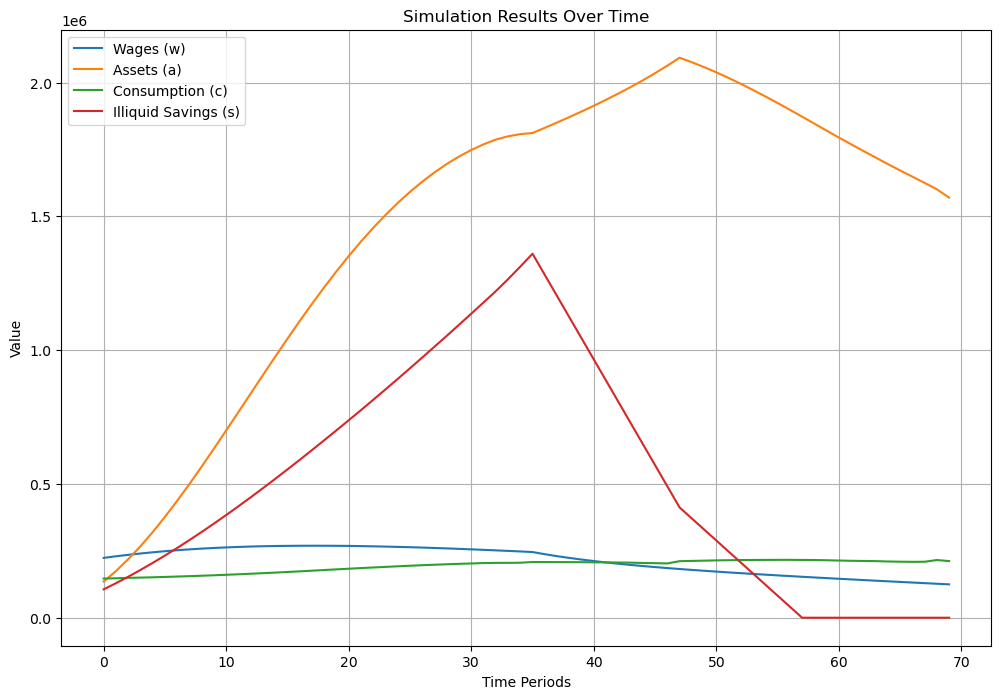

In [5]:
time = np.arange(par.T)

simulated_data = {
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}

# Create a figure and plot each variable
plt.figure(figsize=(12, 8))
for label, data in simulated_data.items():
    plt.plot(time, data, label=label)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

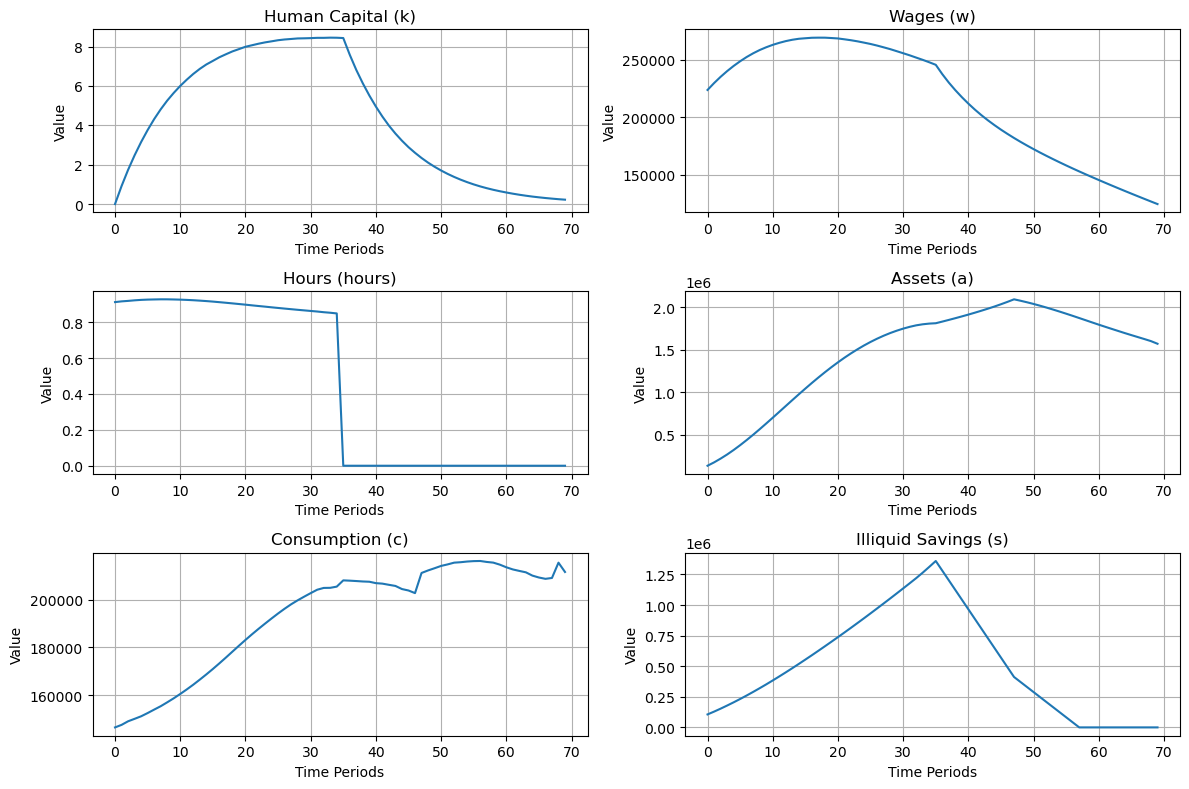

In [7]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": np.mean(model.sim.k[:], axis=0),
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Hours (hours)": np.mean(model.sim.h[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}
# Plot each variable in its respective subplot
for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
    ax.plot(time, data)
    ax.set_title(label)
    ax.set_xlabel("Time Periods")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [7]:
model.sol

namespace(a=array([[[[ 3.84141458e-07,  4.02040314e-07,  4.20841388e-07, ...,
                       3.18163075e-07,  3.32947820e-07,  3.48780304e-07],
                     [ 3.84141458e-07,  4.02040314e-07,  4.20841388e-07, ...,
                       3.18163075e-07,  3.32947820e-07,  3.48780304e-07],
                     [ 3.84141458e-07,  4.02040314e-07,  4.20841388e-07, ...,
                       3.18163075e-07,  3.32947820e-07,  3.48780304e-07],
                     ...,
                     [ 7.93359449e+02,  1.03451966e+03,  1.45254363e+03, ...,
                       2.72239845e+05,  2.95727771e+05,  3.09690807e+05],
                     [ 7.93361986e+02,  1.03451088e+03,  1.45255850e+03, ...,
                       2.72239818e+05,  2.95727769e+05,  3.09690788e+05],
                     [ 7.93356497e+02,  1.03453332e+03,  1.45255286e+03, ...,
                       2.72239791e+05,  2.95727755e+05,  3.09690975e+05]],
            
                    [[ 3.41678970e-07,  3.526802

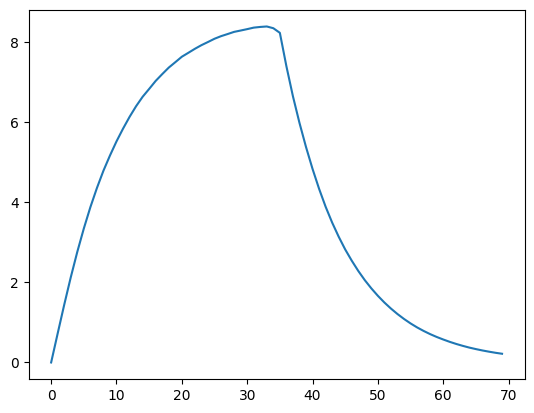

In [8]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


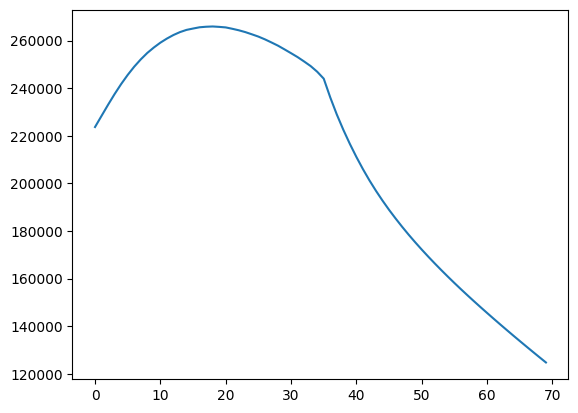

In [9]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


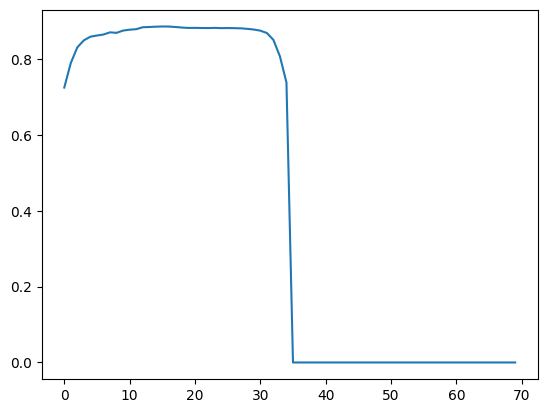

In [10]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


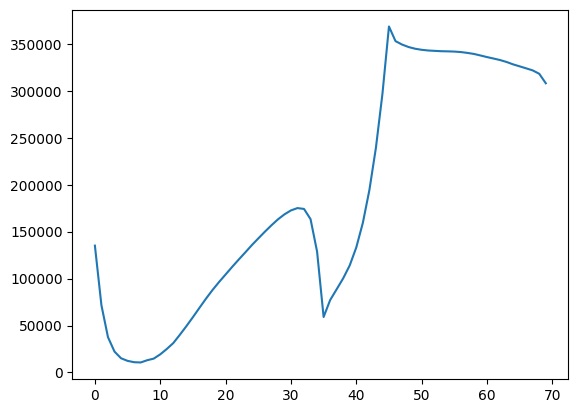

In [11]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


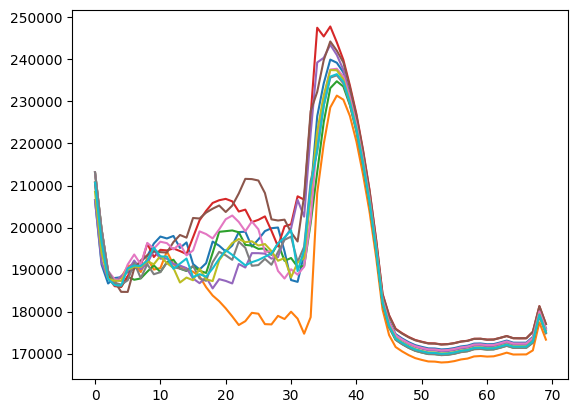

In [12]:
for i in range(10):
    plt.plot(np.arange(par.T),model.sim.c[i,:])


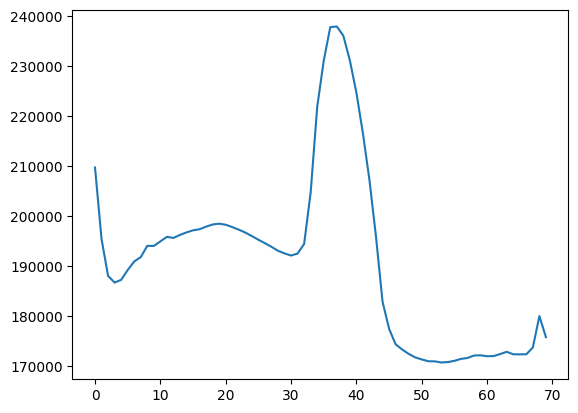

In [13]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


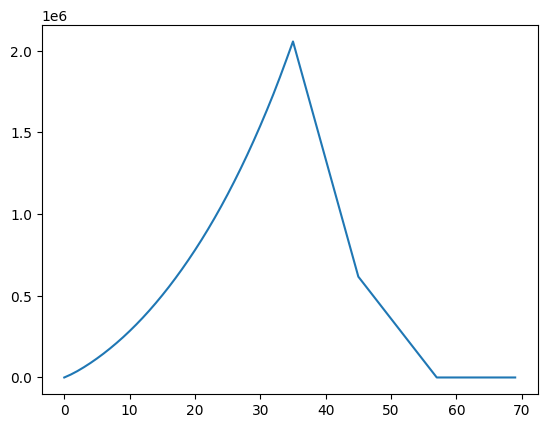

In [14]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


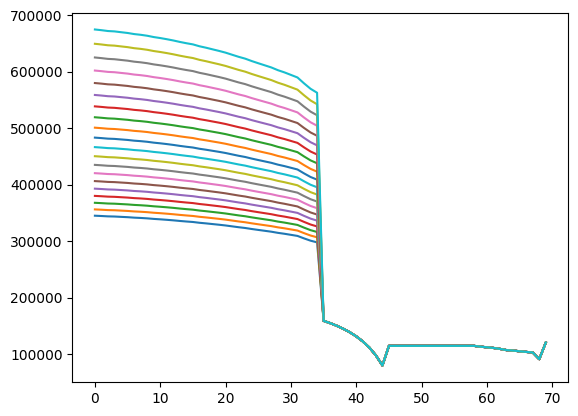

In [15]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [16]:
sol.s

AttributeError: 'types.SimpleNamespace' object has no attribute 's'

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.s[:, 1, 1, i])


In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.a[:, 4, 4, i])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
